In [33]:
import numpy as np

# Decision Tree Regressor model
class DecisionTreeRegressor:
    def __init__(self, max_depth = 5, min_samples_split = 2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth = 0)
    
    def predict(self, X):
        return np.array([self._predict_sample(sample, self.tree) for sample in X])

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape

        if depth >= self.max_depth or n_samples < self.min_samples_split or len(set(y)) == 1:
            return {'value': np.mean(y)}

        best_split = self._find_best_split(X, y, n_features)
        if not best_split:
            return {'value': np.mean(y)}

        left_idxs, right_idxs = best_split['left_idxs'], best_split['right_idxs']
        left_tree = self._build_tree(X[left_idxs], y[left_idxs], depth + 1)
        right_tree = self._build_tree(X[right_idxs], y[right_idxs], depth + 1)

        return {
            'feature': best_split['feature'],
            'threshold': best_split['threshold'],
            'left': left_tree,
            'right': right_tree
        }

    def _find_best_split(self, X, y, n_features):
        best_split = {}
        best_mse = float('inf')

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                left_idxs = np.where(X[:, feature] <= threshold)[0]
                right_idxs = np.where(X[:, feature] > threshold)[0]

                if len(left_idxs) == 0 or len(right_idxs) == 0:
                    continue

                mse = self._calculate_mse(y[left_idxs], y[right_idxs])
                if mse < best_mse:
                    best_split = {
                        'feature': feature,
                        'threshold': threshold,
                        'left_idxs': left_idxs,
                        'right_idxs': right_idxs
                    }
                    best_mse = mse

                
        return best_split if best_split else None

    def _calculate_mse(self, left_y, right_y):
        mse = 0
        for y_split in [left_y, right_y]:
            if len(y_split) > 0:
                mse += len(y_split) * np.var(y_split)

        return mse 

    def _predict_sample(self, sample, tree):
        if 'value' in tree:
            return tree['value']

        feature = tree['feature']
        threshold = tree['threshold']

        if sample[feature] < threshold:
            return self._predict_sample(sample, tree['left'])
        else:
            return self._predict_sample(sample, tree['right'])

In [34]:
# Decision Tree Classifier model
class DecisionTreeClassifier:
    def __init__(self, max_depth = 5, min_samples_split = 2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth = 0)

    def predict(self, X):
        return np.array([self._predict_sample(sample, self.tree) for sample in X])
    
    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        if depth >= self.max_depth or n_samples < self.min_samples_split or len(set(y)) == 1:
            return {'value': self._most_common_label(y)}
        
        best_split = self._find_best_split(X, y, n_features)

        if not best_split:
            return {'value': self._most_common_label(y)}
        
        left_idxs, right_idxs = best_split['left_idxs'], best_split['right_idxs']
        left_tree = self._build_tree(X[left_idxs], y[left_idxs], depth + 1)
        right_tree = self._build_tree(X[right_idxs], y[right_idxs], depth + 1)

        return {
            'feature': best_split['feature'],
            'threshold': best_split['threshold'],
            'left': left_tree,
            'right': right_tree
        }
    
    def _find_best_split(self, X, y, n_features):
        best_split = {}
        best_gini = float('inf')

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:

                left_idxs = np.where(X[:, feature] <= threshold)[0]
                right_idxs = np.where(X[:, feature] > threshold)[0]

                if len(left_idxs) == 0 or len(right_idxs) == 0:
                    continue

                gini = self._calculate_gini(y[left_idxs], y[right_idxs])

                if gini < best_gini:

                    best_split = {
                        'feature': feature,
                        'threshold': threshold,
                        'left_idxs': left_idxs,
                        'right_idxs': right_idxs
                    }

                    best_gini = gini

        return best_split if best_split else None
    
    def _calculate_gini(self, left_y, right_y):

        def gini_impurity(y):

            m = len(y)

            if m == 0:
                return 0
            
            probs = [np.sum(y == c) / m for c in np.unique(y)]

            return 1 - sum(p ** 2 for p in probs)
        
        m = len(left_y) + len(right_y)
        gini_left = gini_impurity(left_y)
        gini_right = gini_impurity(right_y)

        return (len(left_y) / m) * gini_left + (len(right_y) / m) * gini_right
    
    def _most_common_label(self, y):
        return np.bincount(y).argmax()
    
    def _predict_sample(self, sample, tree):

        if 'value' in tree:
            return tree['value']
        
        feature = tree['feature']
        thereshold = tree['threshold']

        if sample[feature] <= thereshold:
            return self._predict_sample(sample, tree['left'])
        else:
            return self._predict_sample(sample, tree['right'])

In [35]:
# Testing 
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# synthetic data generation for regression
X, y = make_regression(n_samples = 200, n_features = 1, noise = 10, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

regressor = DecisionTreeRegressor(max_depth = 3, min_samples_split = 5)
regressor.fit(X_train, y_train)

pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, pred)

print('MSE of Decision Tree Regressor:', mse)

MSE of Decision Tree Regressor: 352.8850082313449


In [36]:
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

# synthetic data generation for classification
X_c, y_c = make_classification(n_samples = 200, n_features = 2, n_classes = 2, n_informative=2, n_redundant=0, n_repeated= 0, random_state = 0)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size = 0.2, random_state = 0)

classifier = DecisionTreeClassifier(max_depth=3, min_samples_split=5)
classifier.fit(X_train_c, y_train_c)

pred_c = classifier.predict(X_test_c)
accuracy = accuracy_score(y_test_c, pred_c)

print('Accuracy of Decision Tree Classifier:', accuracy)

Accuracy of Decision Tree Classifier: 0.875


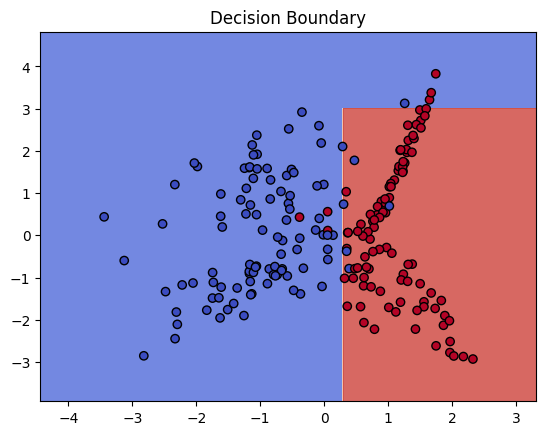

In [37]:
# Visualization
import matplotlib.pyplot as plt

def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha = 0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c = y, edgecolor = 'k', cmap=plt.cm.coolwarm)

    plt.title('Decision Boundary')
    plt.show()

plot_decision_boundary(X_c, y_c, classifier)

In [38]:
# Verifying against scikit-learn's models

from sklearn.tree import DecisionTreeRegressor as SklearnRegressor

sklearn_regressor = SklearnRegressor(max_depth=3, min_samples_split=5)
sklearn_regressor.fit(X_train, y_train)
sklearn_preds = sklearn_regressor.predict(X_test)

print("Sklearn MSE (Regression):", mean_squared_error(y_test, sklearn_preds))

Sklearn MSE (Regression): 343.85273335039585


In [39]:
from sklearn.tree import DecisionTreeClassifier as SklearnClassifier

sklearn_classifier = SklearnClassifier(max_depth=3, min_samples_split=5)
sklearn_classifier.fit(X_train_c, y_train_c)
sklearn_preds = sklearn_classifier.predict(X_test_c)

print("Sklearn Accuracy (Classification):", accuracy_score(y_test_c, sklearn_preds))

Sklearn Accuracy (Classification): 0.875
